In [1]:
from baselines.common.vec_env import VecEnvWrapper, SubprocVecEnv
from pred_learn.envs import *
from a2c_ppo_acktr.envs import VecPyTorch

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
from a2c_ppo_acktr import algo
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.utils import get_vec_normalize, update_linear_schedule
from a2c_ppo_acktr.visualize import visdom_plot
from collections import deque
import copy
import glob
import os
import time
from collections import deque

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
import torch
# from skimage.transform import resize
import os
import numpy as np

In [5]:
MAX_STEPS = 500
TOTAL_STEPS = 10000
ENVS = [
    "CarRacing-v0",
    "Snake-ple-v0",
    "TetrisA-v2",
    "PuckWorld-ple-v0",
    "WaterWorld-ple-v0",
    "PixelCopter-ple-v0",
    "CubeCrash-v0",
    "Catcher-ple-v0",
    "Pong-ple-v0",
]
ENV_ID = 'MountainCar-v0'
SEED = 0

# RECORD_DIR = "recorded/{}/".format(ENV_ID)
# FILE_NO = 1


# try:
#     os.makedirs(RECORD_DIR)
# except FileExistsError:
#     pass

In [6]:
env = make_env(ENV_ID, SEED)

In [7]:
env._env.reward_range

(-inf, inf)

In [8]:
class Object(object):
    pass

args = Object()
args.cuda = True
args.vis = False
args.num_processes = 4
args.seed = SEED

args.env_name = ENV_ID

args.gamma = 0.99
args.log_dir = "tests"
args.log_interval = 1
args.eval_interval = 10
eval_log_dir = args.log_dir + "_eval"
args.add_timestep = False
args.add_padding = False
args.recurrent_policy = False
args.algo = "ppo"
args.value_loss_coef = 0.5
args.entropy_coef = 0.01
args.lr = 7e-4
args.eps = 1e-5
args.alpha = 0.99
args.max_grad_norm = 0.5
args.num_steps = 15
args.use_linear_lr_decay = False
args.use_gae = False
args.tau = 0.95
args.clip_param = 0.2
args.ppo_epoch = 4
args.num_mini_batch = 32
args.use_linear_clip_decay = False
args.save_interval = 1000
args.save_dir = "save_dir"

num_updates = 100000

try:
    os.makedirs(args.log_dir)
except OSError:
    files = glob.glob(os.path.join(args.log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)
        
try:
    os.makedirs(eval_log_dir)
except OSError:
    files = glob.glob(os.path.join(eval_log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)


In [9]:
torch.set_num_threads(1)
device = torch.device("cuda:0" if args.cuda else "cpu")

if args.vis:
    from visdom import Visdom
    viz = Visdom(port=args.port)
    win = None

envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                     args.gamma, args.log_dir, args.add_timestep, device, True,
                     padding_type=args.add_padding)

# envs = make_rl_envs(args.env_name, args.num_processes, args.seed, device)
    
actor_critic = Policy(envs.observation_space.shape, envs.action_space,
    base_kwargs={'recurrent': args.recurrent_policy})
actor_critic.to(device)

if args.algo == 'a2c':
    agent = algo.A2C_ACKTR(actor_critic, args.value_loss_coef,
                           args.entropy_coef, lr=args.lr,
                           eps=args.eps, alpha=args.alpha,
                           max_grad_norm=args.max_grad_norm)
elif args.algo == 'ppo':
    agent = algo.PPO(actor_critic, args.clip_param, args.ppo_epoch, args.num_mini_batch,
                     args.value_loss_coef, args.entropy_coef, lr=args.lr,
                           eps=args.eps,
                           max_grad_norm=args.max_grad_norm)
elif args.algo == 'acktr':
    agent = algo.A2C_ACKTR(actor_critic, args.value_loss_coef,
                           args.entropy_coef, acktr=True)

rollouts = RolloutStorage(args.num_steps, args.num_processes,
                    envs.observation_space.shape, envs.action_space,
                    actor_critic.recurrent_hidden_state_size)

In [10]:
envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                     args.gamma, args.log_dir, args.add_timestep, device, True,
                     padding_type=args.add_padding)

# envs = make_rl_envs(args.env_name, args.num_processes, args.seed, device)


obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

training_stats = {
    'updates': [],
    'num_timesteps': [],
    'mean_reward': [],
    'median_reward': [],
    'min_reward': [],
    'max_reward': []
}

start = time.time()
for j in range(num_updates):

    if args.use_linear_lr_decay:
        # decrease learning rate linearly
        if args.algo == "acktr":
            # use optimizer's learning rate since it's hard-coded in kfac.py
            update_linear_schedule(agent.optimizer, j, num_updates, agent.optimizer.lr)
        else:
            update_linear_schedule(agent.optimizer, j, num_updates, args.lr)

    if args.algo == 'ppo' and args.use_linear_clip_decay:
        agent.clip_param = args.clip_param  * (1 - j / float(num_updates))

    for step in range(args.num_steps):
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step],
                    rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

        # Obser reward and next obs
        obs, reward, done, infos = envs.step(action)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])

        # If done then clean the history of observations.
        masks = torch.FloatTensor([[0.0] if done_ else [1.0]
                                   for done_ in done])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks)

    with torch.no_grad():
        next_value = actor_critic.get_value(rollouts.obs[-1],
                                            rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()

    rollouts.compute_returns(next_value, args.use_gae, args.gamma, args.tau)

    value_loss, action_loss, dist_entropy = agent.update(rollouts)

    rollouts.after_update()

    # save for every interval-th episode or for the last epoch
    if (j % args.save_interval == 0 or j == num_updates - 1) and args.save_dir != "":
        save_path = os.path.join(args.save_dir, args.algo)
        try:
            os.makedirs(save_path)
        except OSError:
            pass

        # A really ugly way to save a model to CPU
        save_model = actor_critic
        if args.cuda:
            save_model = copy.deepcopy(actor_critic).cpu()

        save_model = [save_model,
                      getattr(get_vec_normalize(envs), 'ob_rms', None)]

        torch.save(save_model, os.path.join(save_path, args.env_name + ".pt"))

    total_num_steps = (j + 1) * args.num_processes * args.num_steps

#     if j % args.log_interval == 0 and len(episode_rewards) > 1:
    if len(episode_rewards) > 1:
        end = time.time()
        print("Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n".
            format(j, total_num_steps,
                   int(total_num_steps / (end - start)),
                   len(episode_rewards),
                   np.mean(episode_rewards),
                   np.median(episode_rewards),
                   np.min(episode_rewards),
                   np.max(episode_rewards), dist_entropy,
                   value_loss, action_loss))

        training_stats['updates'].append(j)
        training_stats['num_timesteps'].append(total_num_steps)
        training_stats['mean_reward'].append(np.mean(episode_rewards))
        training_stats['median_reward'].append(np.median(episode_rewards))
        training_stats['min_reward'].append(np.min(episode_rewards))
        training_stats['max_reward'].append(np.max(episode_rewards))

    if (args.eval_interval is not None
            and len(episode_rewards) > 1
            and j % args.eval_interval == 0):
        eval_envs = make_vec_envs(
            args.env_name, args.seed + args.num_processes, args.num_processes,
            args.gamma, eval_log_dir, args.add_timestep, device, True)

        vec_norm = get_vec_normalize(eval_envs)
        if vec_norm is not None:
            vec_norm.eval()
            vec_norm.ob_rms = get_vec_normalize(envs).ob_rms

        eval_episode_rewards = []

        obs = eval_envs.reset()
        eval_recurrent_hidden_states = torch.zeros(args.num_processes,
                        actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(args.num_processes, 1, device=device)

        while len(eval_episode_rewards) < 10:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs, eval_recurrent_hidden_states, eval_masks, deterministic=True)

            # Obser reward and next obs
            obs, reward, done, infos = eval_envs.step(action)

            eval_masks = torch.FloatTensor([[0.0] if done_ else [1.0]
                                            for done_ in done]).to(device)
            for info in infos:
                if info is not None and 'episode' in info.keys():
                    eval_episode_rewards.append(info['episode']['r'])

        eval_envs.close()

        print(" Evaluation using {} episodes: mean reward {:.5f}\n".
            format(len(eval_episode_rewards),
                   np.mean(eval_episode_rewards)))

    if args.vis and j % args.vis_interval == 0:
        try:
            # Sometimes monitor doesn't properly flush the outputs
            win = visdom_plot(viz, win, args.log_dir, args.env_name,
                              args.algo, args.num_env_steps)
        except IOError:
            pass


Updates 13, num timesteps 840, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 14, num timesteps 900, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 15, num timesteps 960, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 16, num timesteps 1020, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 17, num timesteps 1080, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 18, num timesteps 1140, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 19, num timesteps 1200, FPS 32 
 Last 4 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 20, num timesteps 1260, FPS 32 
 Last 4 training episodes: mean/median reward 

KeyboardInterrupt: 

In [ ]:
j

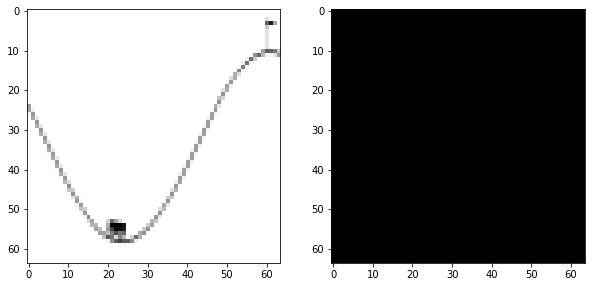

KeyboardInterrupt: 

In [11]:
envs = make_rl_envs(args.env_name, args.num_processes, args.seed,  device)

obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

training_stats = {
    'updates': [],
    'num_timesteps': [],
    'mean_reward': [],
    'median_reward': [],
    'min_reward': [],
    'max_reward': []
}

start = time.time()
for j in range(50):
    for step in range(args.num_steps):
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step],
                    rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

        # Obser reward and next obs
        obs, reward, done, infos = envs.step(action)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])

        # If done then clean the history of observations.
        masks = torch.FloatTensor([[0.0] if done_ else [1.0]
                                   for done_ in done])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks)
        
#         obs = obs.values().clone()
        obs = torch.FloatTensor(obs.cpu().data).cuda()
        obs.requires_grad = True
        next_value = actor_critic.get_value(obs,
                                    rollouts.recurrent_hidden_states[-1],
                                    rollouts.masks[-1])
        next_value[0, ...].mean().backward()        
        
        print("reward", reward[0])
        print("action", action[0])
        
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(obs.detach().cpu().numpy()[0, -1, ...], cmap="gray")        
        
        plt.subplot(1, 2, 2)
        plt.imshow(obs.grad[0,...].sum(dim=0).abs().cpu().numpy(), cmap="gray")        
        
        plt.pause(0.05)


In [ ]:
obs